# Capstone: Airbnb Price Listing Prediction
## Part 3 Feature Engineering & Model Benchmark

_Authors: Evonne Tham_

##  1. Import Necessary Libraries & Load Data 

<div class="alert alert-block alert-info">
    
<b>Model Selection - fixed learning method</b>

- Split the data into train, test, and validation.
- Train as many models as there are hyperparameter combinations on the train set.
- Evaluate each of these models on the validation set.
- Select the model with the best performance on the validation set.
- Retrain the model on the combined train + validation sets using 'winning' hyperparameter combination.
- Estimate generalisation performance on the test set. If the test error is similar to the validation error then we have belief that this model will generalise well to unseen data.
- Finally retrain the model with the choosen hyperparameters on the entire set before production.

<b>Algorithm Selection</b>

We can follow the above reasoning but split the data into independent train, validation, test sets for each learning method we are testing.
This obviously only works if we have a large amount of data at our disposal.

</div>

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
import time
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, accuracy_score
# from xgboost import plot_importance


#Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in Data 
df = pd.read_csv('../datasets/final_df.csv')

#Set id as index 
df.set_index('id', inplace=True)

print(f"Total Number of Listing: {df.shape[0]} | Total Number of Features: {df.shape[1]}")
df.head(4).T

Total Number of Listing: 11435 | Total Number of Features: 45


id                                                                      35303   \
host_id                                                                 151977   
host_since                                                          2010-06-25   
host_response_time                                                     unknown   
host_response_rate                                                     unknown   
host_acceptance_rate                                                   unknown   
host_is_superhost                                                            0   
host_listings_count                                                          3   
host_identity_verified                                                       1   
neighbourhood                                                       Shibuya Ku   
country_code                                                                JP   
latitude                                                               35.6715   
longitude                                                              139.712   
is_location_exact                                                            1   
property_type                                                        Apartment   
room_type                                                         private_room   
accommodates                                                                 1   
bathrooms                                                                    1   
bedrooms                                                                     1   
beds                                                                         1   
amenities                    tv,internet,wifi,kitchen,paid parking off prem...   
price                                                                     4192   
security_deposit                                                         30000   
cleaning_fee                                                              5000   
guests_included                                                              1   
extra_people                                                                 0   
minimum_nights                                                              28   
maximum_nights                                                            1125   
calendar_updated                                                 19 months ago   
availability_30                                                             29   
availability_60                                                             59   
availability_90                                                             89   
availability_365                                                            89   
number_of_reviews                                                           18   
first_review                                                        2011-12-28   
last_review                                                         2018-07-28   
review_scores_rating                                                    90-99%   
review_scores_accuracy                                                       9   
review_scores_cleanliness                                                    9   
review_scores_checkin                                                        9   
review_scores_communication                                                 10   
review_scores_location                                                      10   
review_scores_value                                                          9   
instant_bookable                                                             0   
cancellation_policy                                                     strict   
time_since_first_review                           2404 days 00:00:00.000000000   

id                                                                      197677  \
host_id                                                                 964081   
host_since                                                     

---
## 2. Feature Engineering 

##### a. Categorical Variables

In [3]:
df_dummies = pd.get_dummies(df, columns=['property_type',
                                 'room_type',
                                 'cancellation_policy',
                                 'neighbourhood',
                                 'host_response_time',
                                 'host_acceptance_rate',
                                 'review_scores_rating',
                                 'review_scores_accuracy',
                                 'review_scores_cleanliness',
                                 'review_scores_checkin',
                                 'review_scores_communication',
                                 'review_scores_location',
                                 'review_scores_value',
                                 'instant_bookable',
                                 'is_location_exact'
                                ], 
                         drop_first = False)

##### b. Amenities

In [4]:
all_amenities = df_dummies['amenities'].str.get_dummies(sep=',')
df_dummies = pd.concat([df_dummies, all_amenities], axis=1)

print(f"Total Number of Listing: {df_dummies.shape[0]} | Total Number of Features: {df_dummies.shape[1]}")

Total Number of Listing: 11435 | Total Number of Features: 323


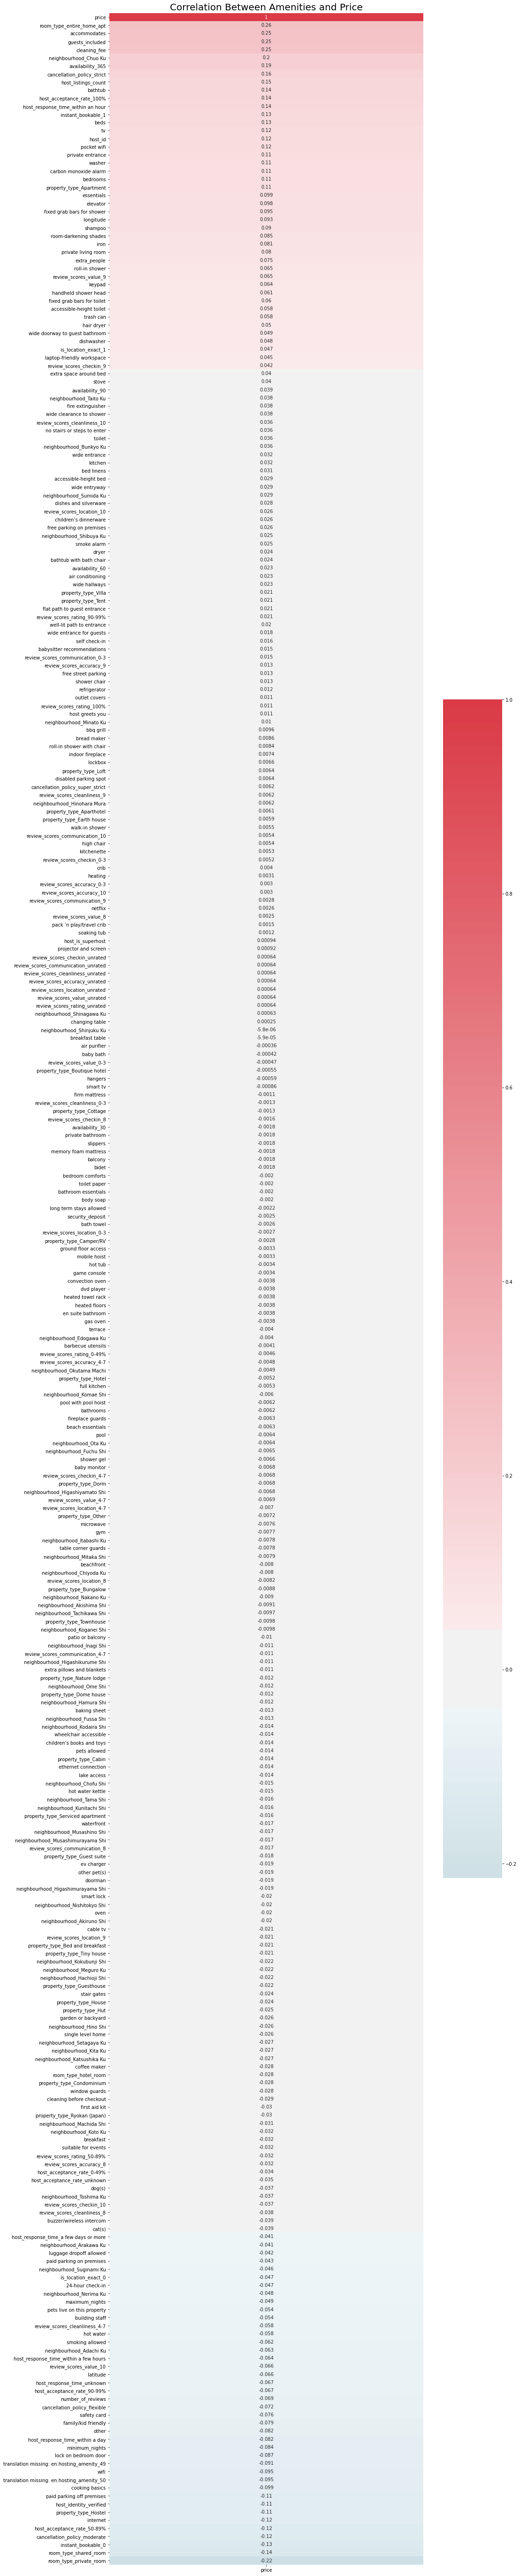

In [8]:
fig = plt.figure(figsize=(15,100))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
corr = df.corr()

sns.heatmap(df_dummies.corr()[['price']].sort_values(by='price', ascending=False), 
            cmap=cmap, 
            center=0, 
            annot=True,
            cbar_kws={"shrink": .9},)

plt.title('Correlation Between Amenities and Price', fontsize=20);

---
## 3. Multicollinearity

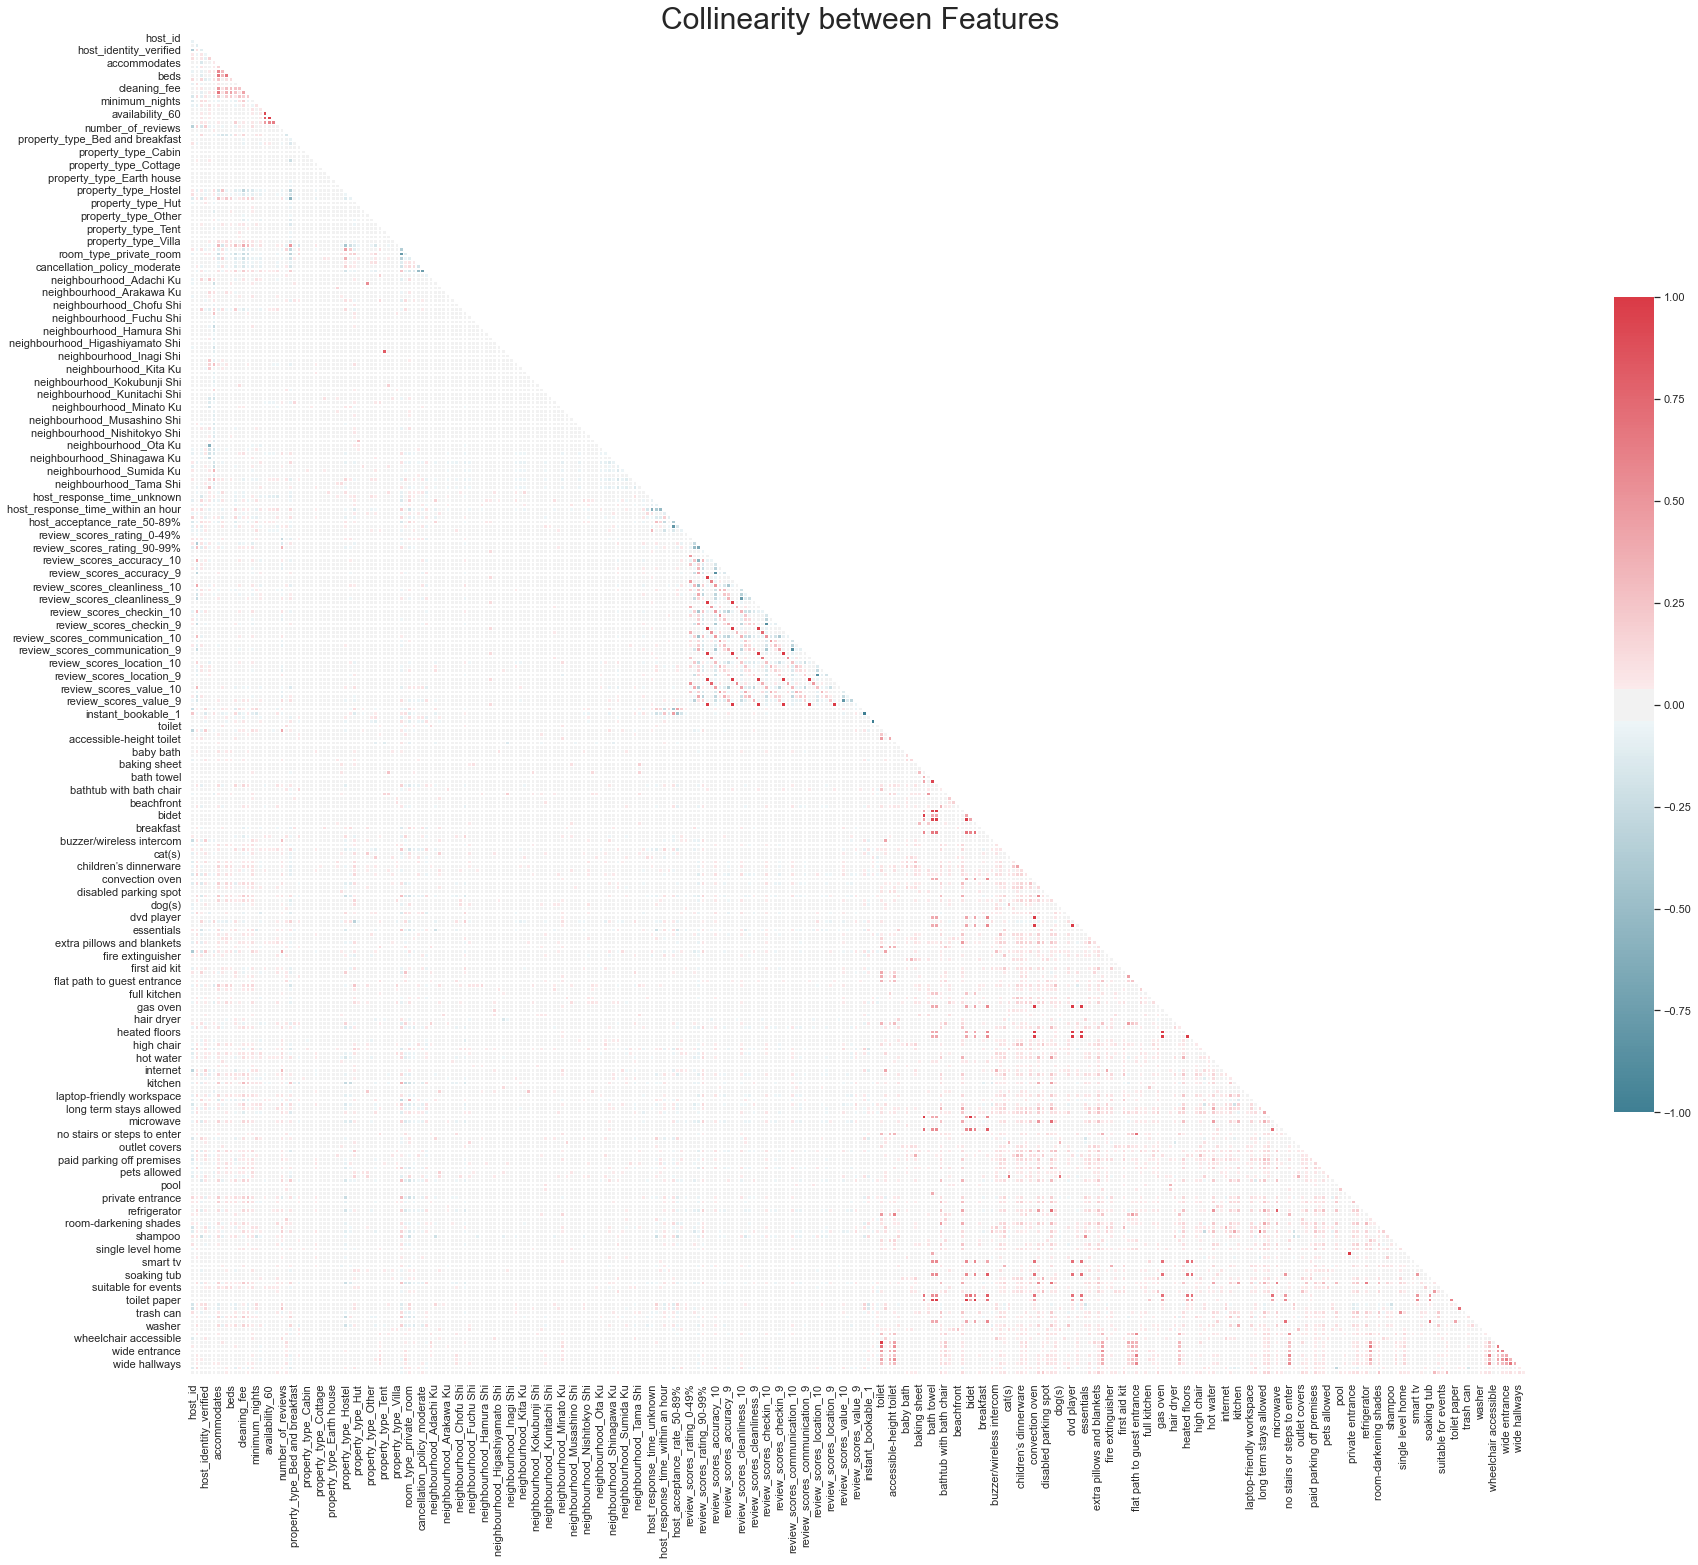

In [9]:
sns.set(style="white")

corr = df_dummies.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(30,30))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})

ax.set_title('Collinearity between Features', fontsize=30);

---
##  4. Model Prep

In [10]:
# Split Dataset into train and test set
train, test = train_test_split(df_dummies, test_size=0.2)

In [12]:
# Save test set for production model
test.to_csv('../datasets/test.csv')

### i. Create X and y variables

In [13]:
features = [col for col in train._get_numeric_data().columns if col != 'price']

X = train[features]
y = train['price']

###  ii. Baseline Prediction 

In [14]:
print(f'The mean value of the target vector is: {np.mean(y)}.')

The mean value of the target vector is: 17966.86018801924.


<div class="alert alert-block alert-info">

<b>Observation:</b> Without any regression modelling, the predicted value for every data point is 17990Â¥.

</div>

### iii. Train/ Validation Splits

In [16]:
# # Splitting data into train, test, and validation set (3:1:1) 
# # Test Set 
# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     test_size=0.2)

# Validation Set 
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

### iv. Baseline score

In [17]:
dummy_constant = DummyRegressor(strategy='constant', constant = 17990.367118495848 )
dummy_constant.fit(X_train, y_train)
print(f'R2 score for baseline model: {dummy_constant.score(X_train, y_train)}.')

R2 score for baseline model: -6.742067809661911e-05.


<div class="alert alert-block alert-info">

<b>Observation:</b> This is a bad r2 score as it indicates that the baseline model explains basically none of the variability of the response data around its mean.

</div>

---
## 5. Modelling

##### Defining Function for modelling

In [18]:
def grid_modeller_val_scorer(classifier): 
    
    '''
    takes arguments "lr", "enet", "svr", "xgb"
    '''
    
    start = time.time()
    
    # Model instantiation
    clf_lr = LinearRegression()
    clf_enet = ElasticNetCV()
    clf_svr = SVR()
    clf_xgb = XGBRegressor()
    
    # Building the model pipelines incl. preprocessing where needed 
    # Setting up the parameter grids
    if classifier == "lr":
        pipe_lr = Pipeline([('ss', StandardScaler()), 
                             ('clf_lr', clf_lr)])
        
        param_grid_lr = [{'clf_lr__fit_intercept': [True, False],
                          'clf_lr__normalize': [True, False]}]
        

        gs = GridSearchCV(pipe_lr, 
                          param_grid_lr, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1, 
                          scoring = "r2") 
        
        gs.fit(X_train, y_train)
        
        
    elif classifier == "enet":
        pipe_enet = Pipeline([('ss', StandardScaler()), 
                             ('clf_enet', clf_enet)])
        
        param_grid_enet = [{'clf_enet__l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
                            'clf_enet__n_alphas': [1,10,100,1000,10000]}]
    
        gs = GridSearchCV(pipe_enet, 
                          param_grid_enet, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1, 
                          scoring = "r2") 
    
        gs.fit(X_train, y_train)
        
        
    elif classifier == "svr":
        pipe_svr = Pipeline([('ss', StandardScaler()),
                             ("clf_svr", clf_svr)])

        param_grid_svr = [{"clf_svr__C":[1,10], 
                          "clf_svr__gamma":[0.001, 0.01, 0.1, 1], 
                          "clf_svr__kernel":('linear', 'rbf')}]  
        
        gs = GridSearchCV(pipe_svr, 
                          param_grid_svr, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1,
                          scoring = "r2") 
        
        gs.fit(X_train, y_train)   
        
    
    elif classifier == "xgb":
        pipe_xgb = Pipeline([('ss', StandardScaler()),
                            ("clf_xgb",clf_xgb)])
        
        param_grid_xgb  = [{'clf_xgb__max_depth': [2,3,4,5,6,7,8,9,10],
                            'clf_xgb__n_estimators': [25, 50, 100, 150, 200, 300],
                            'clf_xgb__learning_rate': [0.001, 0.01, 0.1, 1.0],
                            'clf_xgb__scale_pos_weight':list(range(18,52,2)),
                            'clf_xgb__min_child_weight':[1.5,6,10], 
                            'clf_xgb__gamma':[0,0.03,0.1,0.3]}]
                        
        gs = GridSearchCV(pipe_xgb, 
                          param_grid_xgb, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1,
                          scoring = "r2") 
        
        gs.fit(X_train, y_train)
        
    end = time.time()
        
    #get scores
    train_score = gs.score(X_train, y_train)
    val_score = gs.score(X_val, y_val)
    y_pred = gs.predict(X_val)
    
    #get R2, MSE Score, RMSE score
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = (mean_squared_error(y_val, y_pred))**0.5
    
    
    
    metrics_list= [train_score, val_score, gs.best_score_, r2, mse, rmse]
    
    # Print out total run time 
    print(f"Time taken to run: {round((end - start)/60,1)} minutes")
    print('=========================================')
    print('')

    # print out accuracy, estimator and parameters from GridSearchCV
    print(f'Best train accuracy score = {train_score}')
    print(f'Best validation accuracy score = {val_score}')
    print(f'Best grid search score = {gs.best_score_}')
    print(f'R2 score = {r2}')
    print(f'Mean Square Error = {mse}')
    print(f"Root mean squared error = {rmse}")
    print('=========================================')
    print(f'Best estimator = {gs.best_estimator_}')
    print(f'Best parameters = {gs.best_params_}')
    print('')
    print('=========================================')
    print(f"metrics list for {classifier}:", metrics_list)
    
    return

### 5.1. GridSearch for Hyperparameter Tuning

#### i. Linear Regression Regressor

In [19]:
grid_modeller_val_scorer("lr")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished


Time taken to run: 0.1 minutes

Best train accuracy score = 0.3735377034366105
Best validation accuracy score = -3.391688628085446e+22
Best grid search score = -5.324013187631203e+24
R2 score = -3.391688628085446e+22
Mean Square Error = 1.5237004478863336e+31
Root mean squared error = 3903460577342025.0
Best estimator = Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf_lr',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Best parameters = {'clf_lr__fit_intercept': True, 'clf_lr__normalize': False}

metrics list for lr: [0.3735377034366105, -3.391688628085446e+22, -5.324013187631203e+24, -3.391688628085446e+22, 1.5237004478863336e+31, 3903460577342025.0]


#### ii. ElasticNetCV

In [23]:
grid_modeller_val_scorer("enet")

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed: 31.4min finished


Time taken to run: 31.4 minutes

Best train accuracy score = 0.36345970933209637
Best validation accuracy score = 0.332805936230125
Best grid search score = 0.3327583057022928
R2 score = 0.332805936230125
Mean Square Error = 299733850.9717852
Root mean squared error = 17312.82331024565
Best estimator = Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf_enet',
                 ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
                              fit_intercept=True, l1_ratio=1, max_iter=1000,
                              n_alphas=10, n_jobs=None, normalize=False,
                              positive=False, precompute='auto',
                              random_state=None, selection='cyclic', tol=0.0001,
                              verbose=0))],
         verbose=False)
Best parameters = {'clf_enet__l1_ratio': 1, 'clf_enet__n_alphas': 10}

metrics list for enet: [0.3634597

#### iii. Support Vector Regressor

In [24]:
grid_modeller_val_scorer("svr")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 18.4min finished


Time taken to run: 18.7 minutes

Best train accuracy score = 0.14775435164455297
Best validation accuracy score = 0.13036956377234588
Best grid search score = 0.1341175135899758
R2 score = 0.13036956377234588
Mean Square Error = 390677456.1212116
Root mean squared error = 19765.562378065835
Best estimator = Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf_svr',
                 SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma=0.001, kernel='linear', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Best parameters = {'clf_svr__C': 10, 'clf_svr__gamma': 0.001, 'clf_svr__kernel': 'linear'}

metrics list for svr: [0.14775435164455297, 0.13036956377234588, 0.1341175135899758, 0.13036956377234588, 390677456.1212116, 19765.562378065835]


#### iv. Extreme Gradient Boosting Trees Regressor ("XGB")

In [ ]:
grid_modeller_val_scorer("xgb")

Fitting 5 folds for each of 44064 candidates, totalling 220320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### 5.2 Model Evaluation
The evaluation metrics used will be mean squared error (for loss) and r squared (for accuracy).

In [ ]:
metrics_list= ["train_score", "val_score", "gs.best_score_", "r2", "mse", "rmse"]

lr = [0.3735377034366105, -3.391688628085446e+22, 
      -5.324013187631203e+24, -3.391688628085446e+22, 
      1.5237004478863336e+31, 3903460577342025.0]
    
enet = [0.36345970933209637, 0.332805936230125, 
        0.3327583057022928, 0.332805936230125, 
        299733850.9717852, 17312.82331024565]

svr = [0.14775435164455297, 0.13036956377234588, 
       0.1341175135899758, 0.13036956377234588, 
       390677456.1212116, 19765.562378065835]

xgb = []


eval_data = [knn, rf, gb, xgb, svc]

column_names = metrics_list

index = ["Linear Regression", "ElasticNetCV", "Support Vector Regressor", "XGBoost"]

eval_df = pd.DataFrame(eval_data, columns=column_names, index=index)
    
eval_df = eval_df.round(decimals = 4)
eval_df

##### Feature Importance

In [ ]:
# option 1 

# ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
# ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
# ft_weights_xgb_reg.head(10)


# option 2
#Visualizing top features in our production model. 
features = xgb.feature_importances_
key_features = pd.Series(features, index=X.columns)
sorted_features = key_features.sort_values(ascending=False).head(30)
sorted_features.head(10)

In [ ]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(sorted_features.index, sorted_features.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

##### Save Final Dataframe

In [ ]:
train.to_csv('../datasets/train.csv')

----> Proceed to the next notebook for Model Tuning